In [ ]:
!pip install opendatasets

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.94G/9.94G [02:54<00:00, 61.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/elmadafri/the-wildfire-dataset/versions/3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import os
import PIL
from PIL import ImageFile

In [ ]:
# Avoid Decompression Bomb Warning
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Define the paths to your dataset
train_dir = r'/root/.cache/kagglehub/datasets/elmadafri/the-wildfire-dataset/versions/3/the_wildfire_dataset_2n_version/train'
valid_dir = r'/root/.cache/kagglehub/datasets/elmadafri/the-wildfire-dataset/versions/3/the_wildfire_dataset_2n_version/val'
test_dir = r'/root/.cache/kagglehub/datasets/elmadafri/the-wildfire-dataset/versions/3/the_wildfire_dataset_2n_version/test'

In [ ]:
# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32


In [ ]:
# Class weights to handle class imbalance
class_weights = {0: 1.0, 1: 1.58}  # Adjusted based on class imbalance

In [ ]:
# Improved Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.2,
    fill_mode='nearest'
)

In [ ]:

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Load dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 1887 images belonging to 2 classes.


In [ ]:
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 402 images belonging to 2 classes.


In [ ]:

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 410 images belonging to 2 classes.


In [ ]:
# Load MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build the model with additional layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Define callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


In [ ]:
# Train the model with class weights and callbacks
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 1/59 ━━━━━━━━━━━━━━━━━━━━ 18:44 19s/step - accuracy: 0.4062 - loss: 1.4314

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


41/59 ━━━━━━━━━━━━━━━━━━━━ 3:06 10s/step - accuracy: 0.4673 - loss: 1.3844

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 755s 13s/step - accuracy: 0.4741 - loss: 1.3712 - val_accuracy: 0.5174 - val_loss: 0.7122 - learning_rate: 1.0000e-05
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 744s 13s/step - accuracy: 0.4920 - loss: 1.2744 - val_accuracy: 0.5448 - val_loss: 0.7036 - learning_rate: 1.0000e-05
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 719s 12s/step - accuracy: 0.5262 - loss: 1.2042 - val_accuracy: 0.5721 - val_loss: 0.6906 - learning_rate: 1.0000e-05
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 724s 12s/step - accuracy: 0.5675 - loss: 1.1482 - val_accuracy: 0.5970 - val_loss: 0.6777 - learning_rate: 1.0000e-05
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 706s 12s/step - accuracy: 0.5795 - loss: 1.1600 - val_accuracy: 0.6144 - val_loss: 0.6614 - learning_rate: 1.0000e-05
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 707s 12s/step - accuracy: 0.5480 - loss: 1.1218 - val_accuracy: 0.6194 - val_loss: 0.6459 - learning_rate: 1.0000e-05
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 713s 12s/step - accuracy: 0.5747 - lo

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/IOT MINI Project/wildfire.h5')

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


 4/13 ━━━━━━━━━━━━━━━━━━━━ 1:08 8s/step - accuracy: 0.7936 - loss: 0.4513

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 5/13 ━━━━━━━━━━━━━━━━━━━━ 1:02 8s/step - accuracy: 0.7974 - loss: 0.4490

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 134s 10s/step - accuracy: 0.8074 - loss: 0.4360
Test Accuracy: 82.93%


 4/13 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step 

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 5/13 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 127s 9s/step
Classification Report:
               precision    recall  f1-score   support

        fire       0.76      0.81      0.79       159
      nofire       0.88      0.84      0.86       251

    accuracy                           0.83       410
   macro avg       0.82      0.83      0.82       410
weighted avg       0.83      0.83      0.83       410



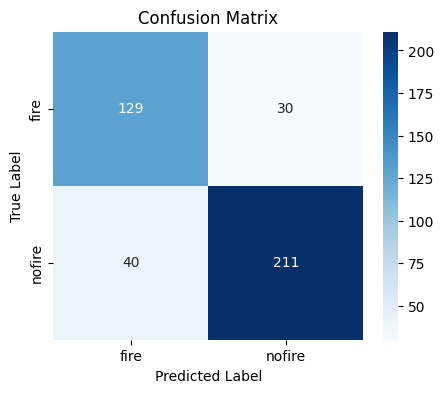

ROC-AUC Score: 0.8951


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load the saved model
model = load_model('/content/drive/MyDrive/IOT MINI Project/wildfire.h5')

# Get class labels
class_indices = test_generator.class_indices  # {'fire': 0, 'no_fire': 1}
index_to_class = {v: k for k, v in class_indices.items()}  # {0: 'fire', 1: 'no_fire'}

# Get true labels and predictions
y_true = test_generator.classes  # True labels
y_pred_probs = model.predict(test_generator)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary classes

# Convert numeric predictions to class names
y_true_labels = [index_to_class[i] for i in y_true]
y_pred_labels = [index_to_class[i] for i in y_pred.flatten()]

# Print classification report
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC Score
auc_score = roc_auc_score(y_true, y_pred_probs)
print(f"ROC-AUC Score: {auc_score:.4f}")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


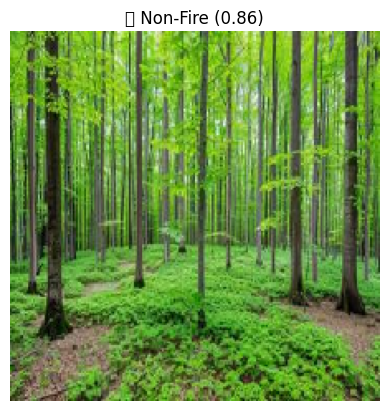

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


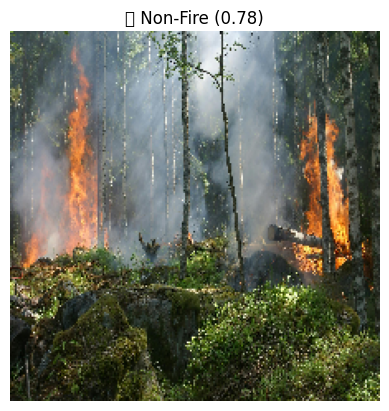

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


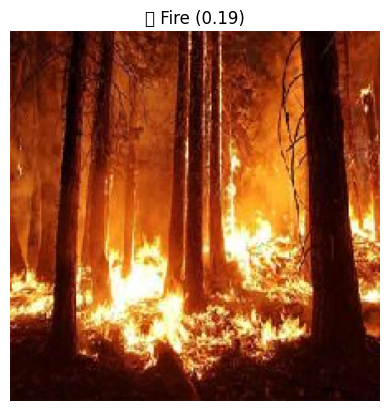

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load the trained model
model_path = "/content/drive/MyDrive/IOT MINI Project/wildfire.h5"
model = tf.keras.models.load_model(model_path)

# Path to the folder containing test images
test_folder_path = "/content/drive/MyDrive/testfolder"  #  folder path

# Function to preprocess and predict images in the folder
def predict_images_in_folder(model, folder_path):
    if not os.path.exists(folder_path):
        print("Error: The folder does not exist. Check the path!")
        return

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if not image_files:
        print("No images found in the folder!")
        return

    for img_name in image_files:
        img_path = os.path.join(folder_path, img_name)

        # Load and preprocess image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize

        # Make prediction
        prediction = model.predict(img_array)[0][0]
        label = "🔥 Fire" if prediction < 0.5 else "✅ Non-Fire"

        # Display image with prediction
        plt.imshow(img)
        plt.title(f"{label} ({prediction:.2f})")
        plt.axis("off")
        plt.show()

# Run the prediction function
predict_images_in_folder(model, test_folder_path)


In [ ]:
# TensorFlow Lite conversion for Raspberry Pi
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the converted model
tflite_model_path = "/content/drive/MyDrive/IOT MINI Project/wildfire.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")


Saved artifact at '/tmp/tmpj4cnk8qu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138099672434640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138099672436752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138099672438288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138099672438672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138099672433680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138099672442128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138099672440784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138099672445968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138099672440976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138099672446736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1380996724444

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Processing Time: 5.58 seconds


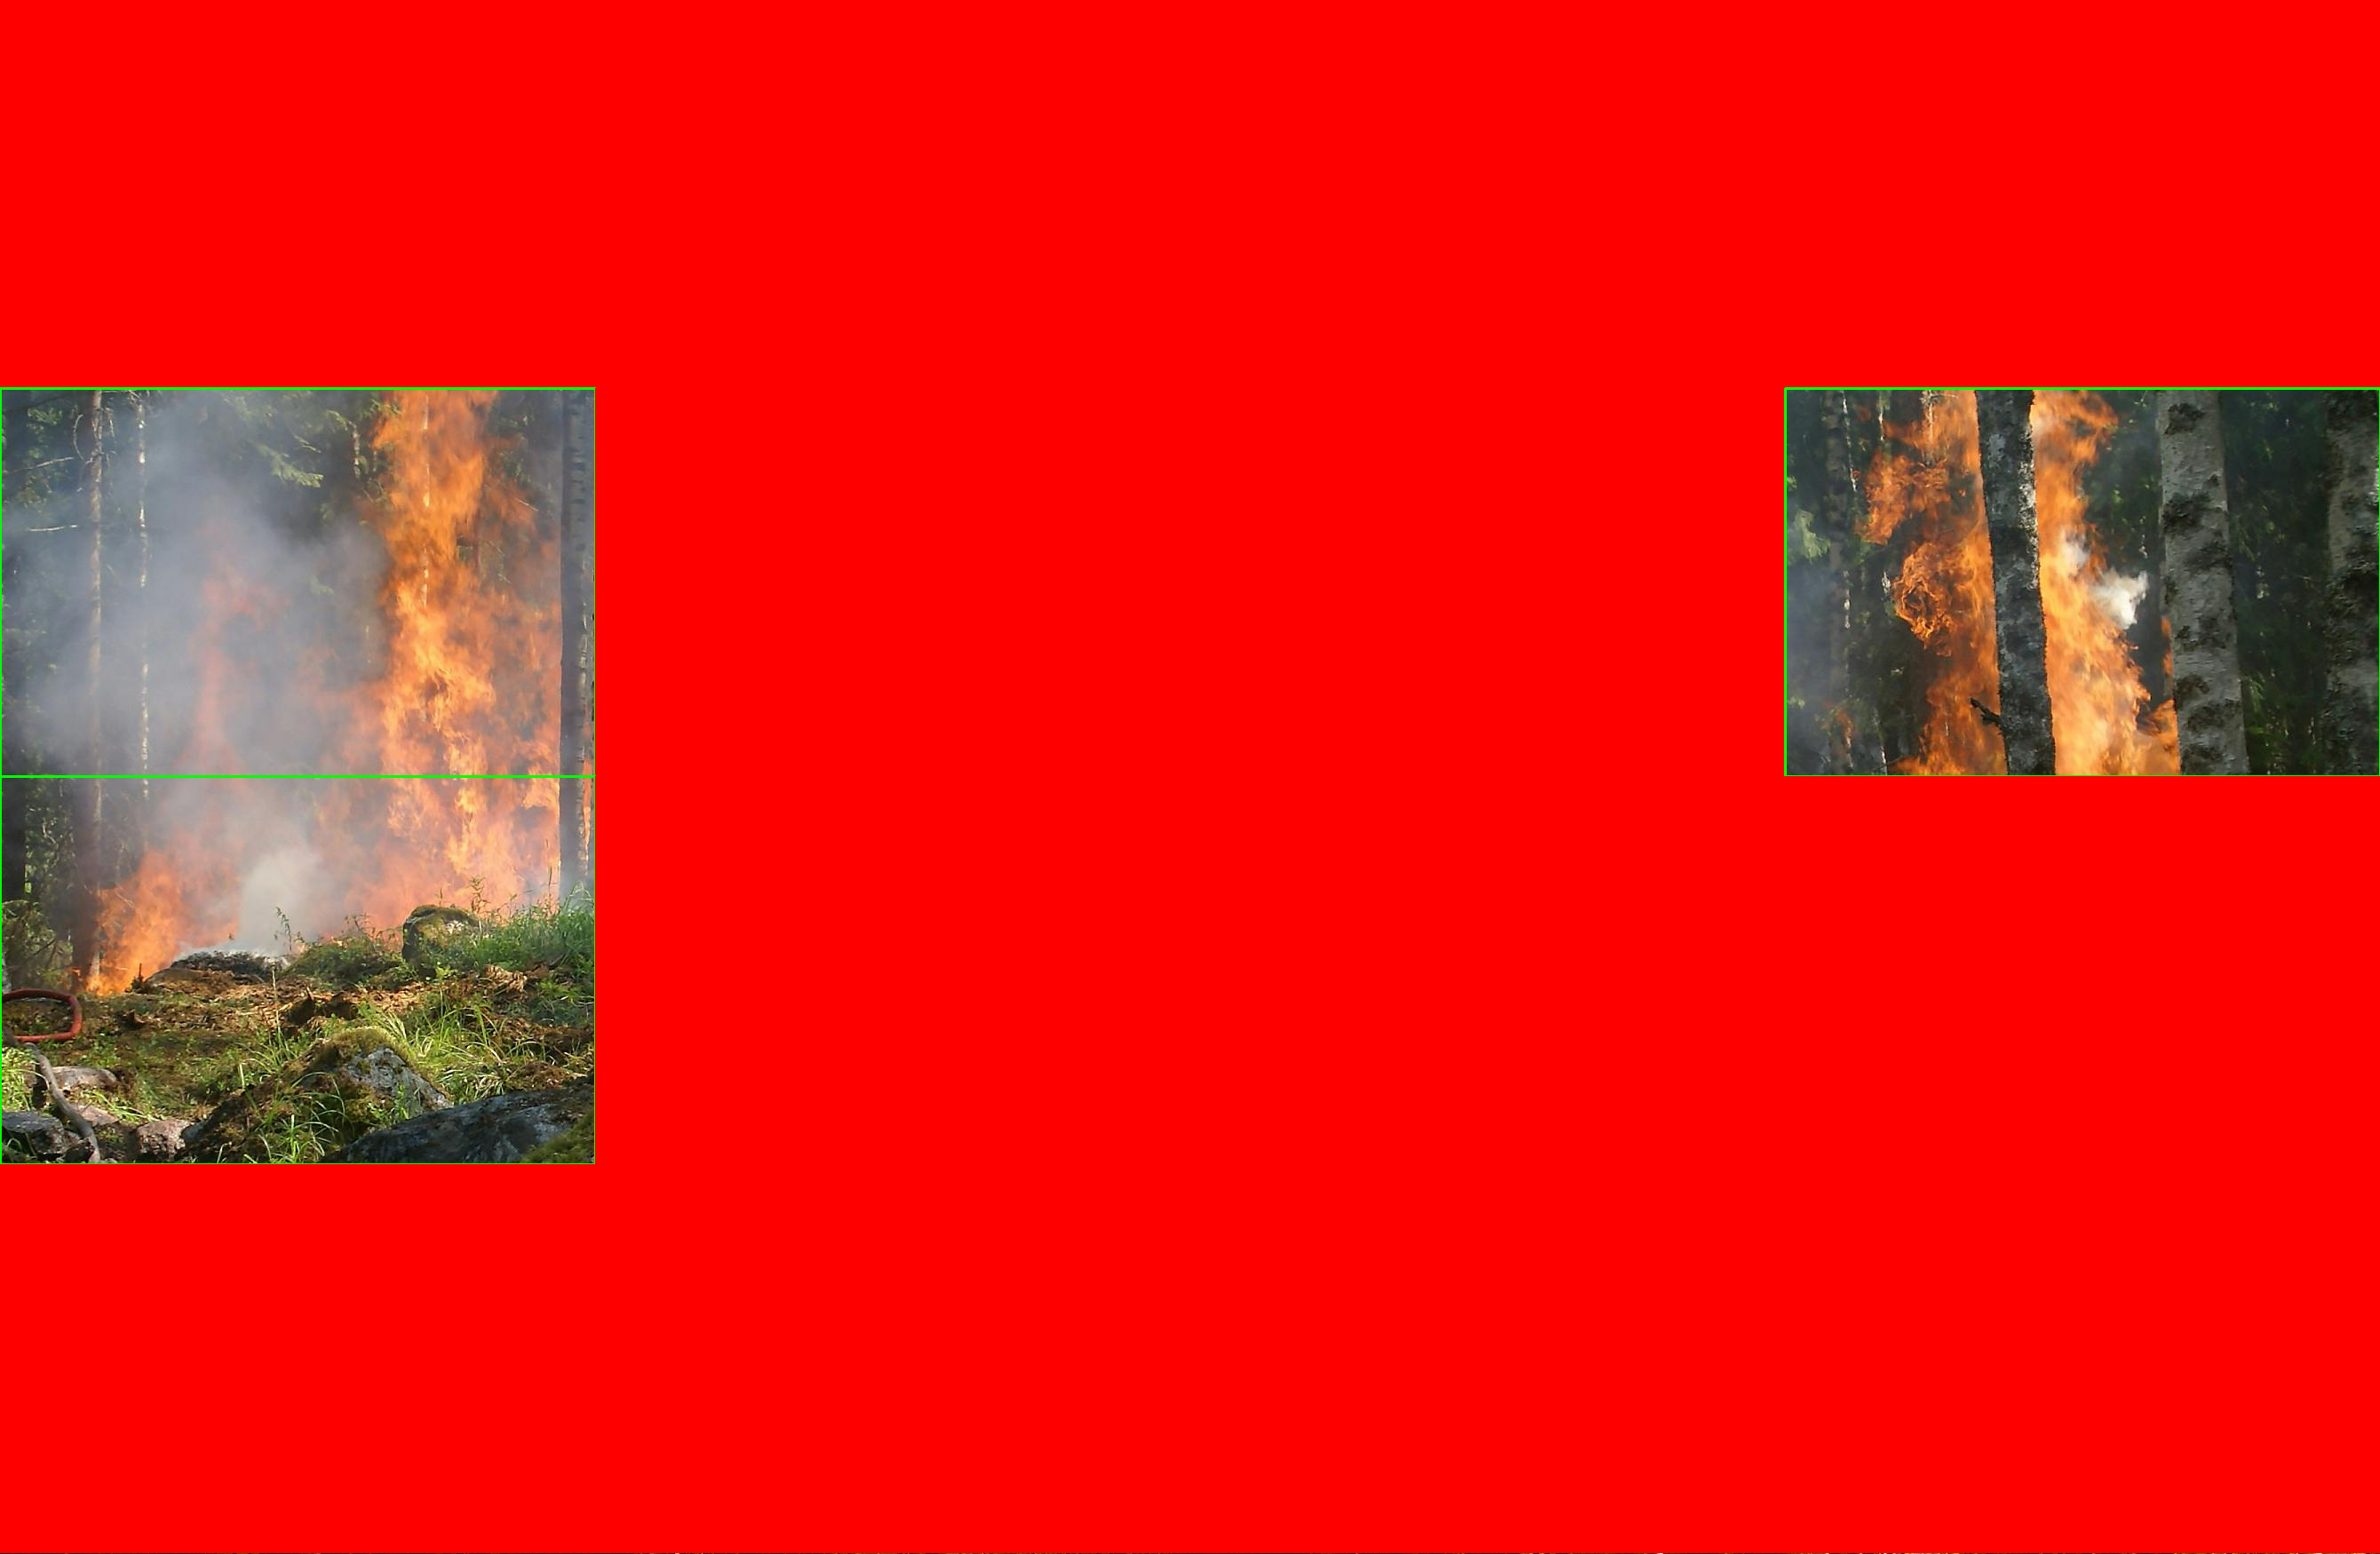

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import time

# Check if running in Google Colab
try:
    from google.colab.patches import cv2_imshow
    COLAB_ENV = True
except ImportError:
    COLAB_ENV = False

# Load the trained MobileNetV2 model
model = tf.keras.models.load_model("/content/drive/MyDrive/IOT MINI Project/wildfire.h5")   # Update with actual model path

def preprocess_image(img, target_size=(224, 224)):
    """Preprocess image for MobileNetV2 input."""
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def detect_fire_with_grid(image_path, grid_size=(4, 4), threshold=0.5):
    """Detects fire in different grid regions of the image."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    cell_h, cell_w = height // grid_size[0], width // grid_size[1]

    fire_map = np.zeros(grid_size)

    # Process each grid cell
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            x1, y1 = j * cell_w, i * cell_h
            x2, y2 = x1 + cell_w, y1 + cell_h

            patch = image[y1:y2, x1:x2]  # Crop grid cell
            processed_patch = preprocess_image(patch)

            prediction = model.predict(processed_patch)[0, 0]  # Fire probability

            if prediction >= threshold:
                fire_map[i, j] = 1
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), -1)  # Highlight fire
            else:
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Normal grid

    return image, fire_map

# Run detection and measure execution time
start_time = time.time()
detected_image, fire_map = detect_fire_with_grid("/content/drive/MyDrive/testfolder/ff.jpg")  # Update with actual test image path
end_time = time.time()

time_taken = end_time - start_time
print(f"Processing Time: {time_taken:.2f} seconds")

# Display result
if COLAB_ENV:
    cv2_imshow(cv2.cvtColor(detected_image, cv2.COLOR_RGB2BGR))  # For Colab
else:
    cv2.imshow("Fire Detection Grid", cv2.cvtColor(detected_image, cv2.COLOR_RGB2BGR))
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [ ]:
import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model("/content/drive/MyDrive/IOT MINI Project/wildfire.h5", compile=False)

# Convert to TFLite with compatibility settings
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]  # Use built-in ops
converter._experimental_lower_tensor_list_ops = True  # Downgrade newer ops
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the model as wildfire_compatible.tflite
with open("/content/drive/MyDrive/IOT Project/wildfire_compatible.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Compatible .tflite model saved as wildfire_compatible.tflite")


Saved artifact at '/tmp/tmp88taivxi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136841586963856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136841586959440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136841586962320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136841586961936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136841586963664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136841586964048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136841481928144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136841481922192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136841586958672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136841481916240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1368414819241

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Processed /content/drive/MyDrive/testfolder/ds.jpg in 5.24 seconds


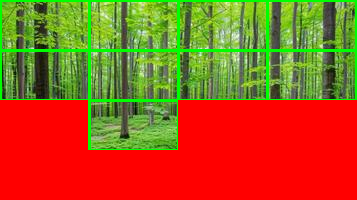

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Processed /content/drive/MyDrive/testfolder/ff.jpg in 2.77 seconds


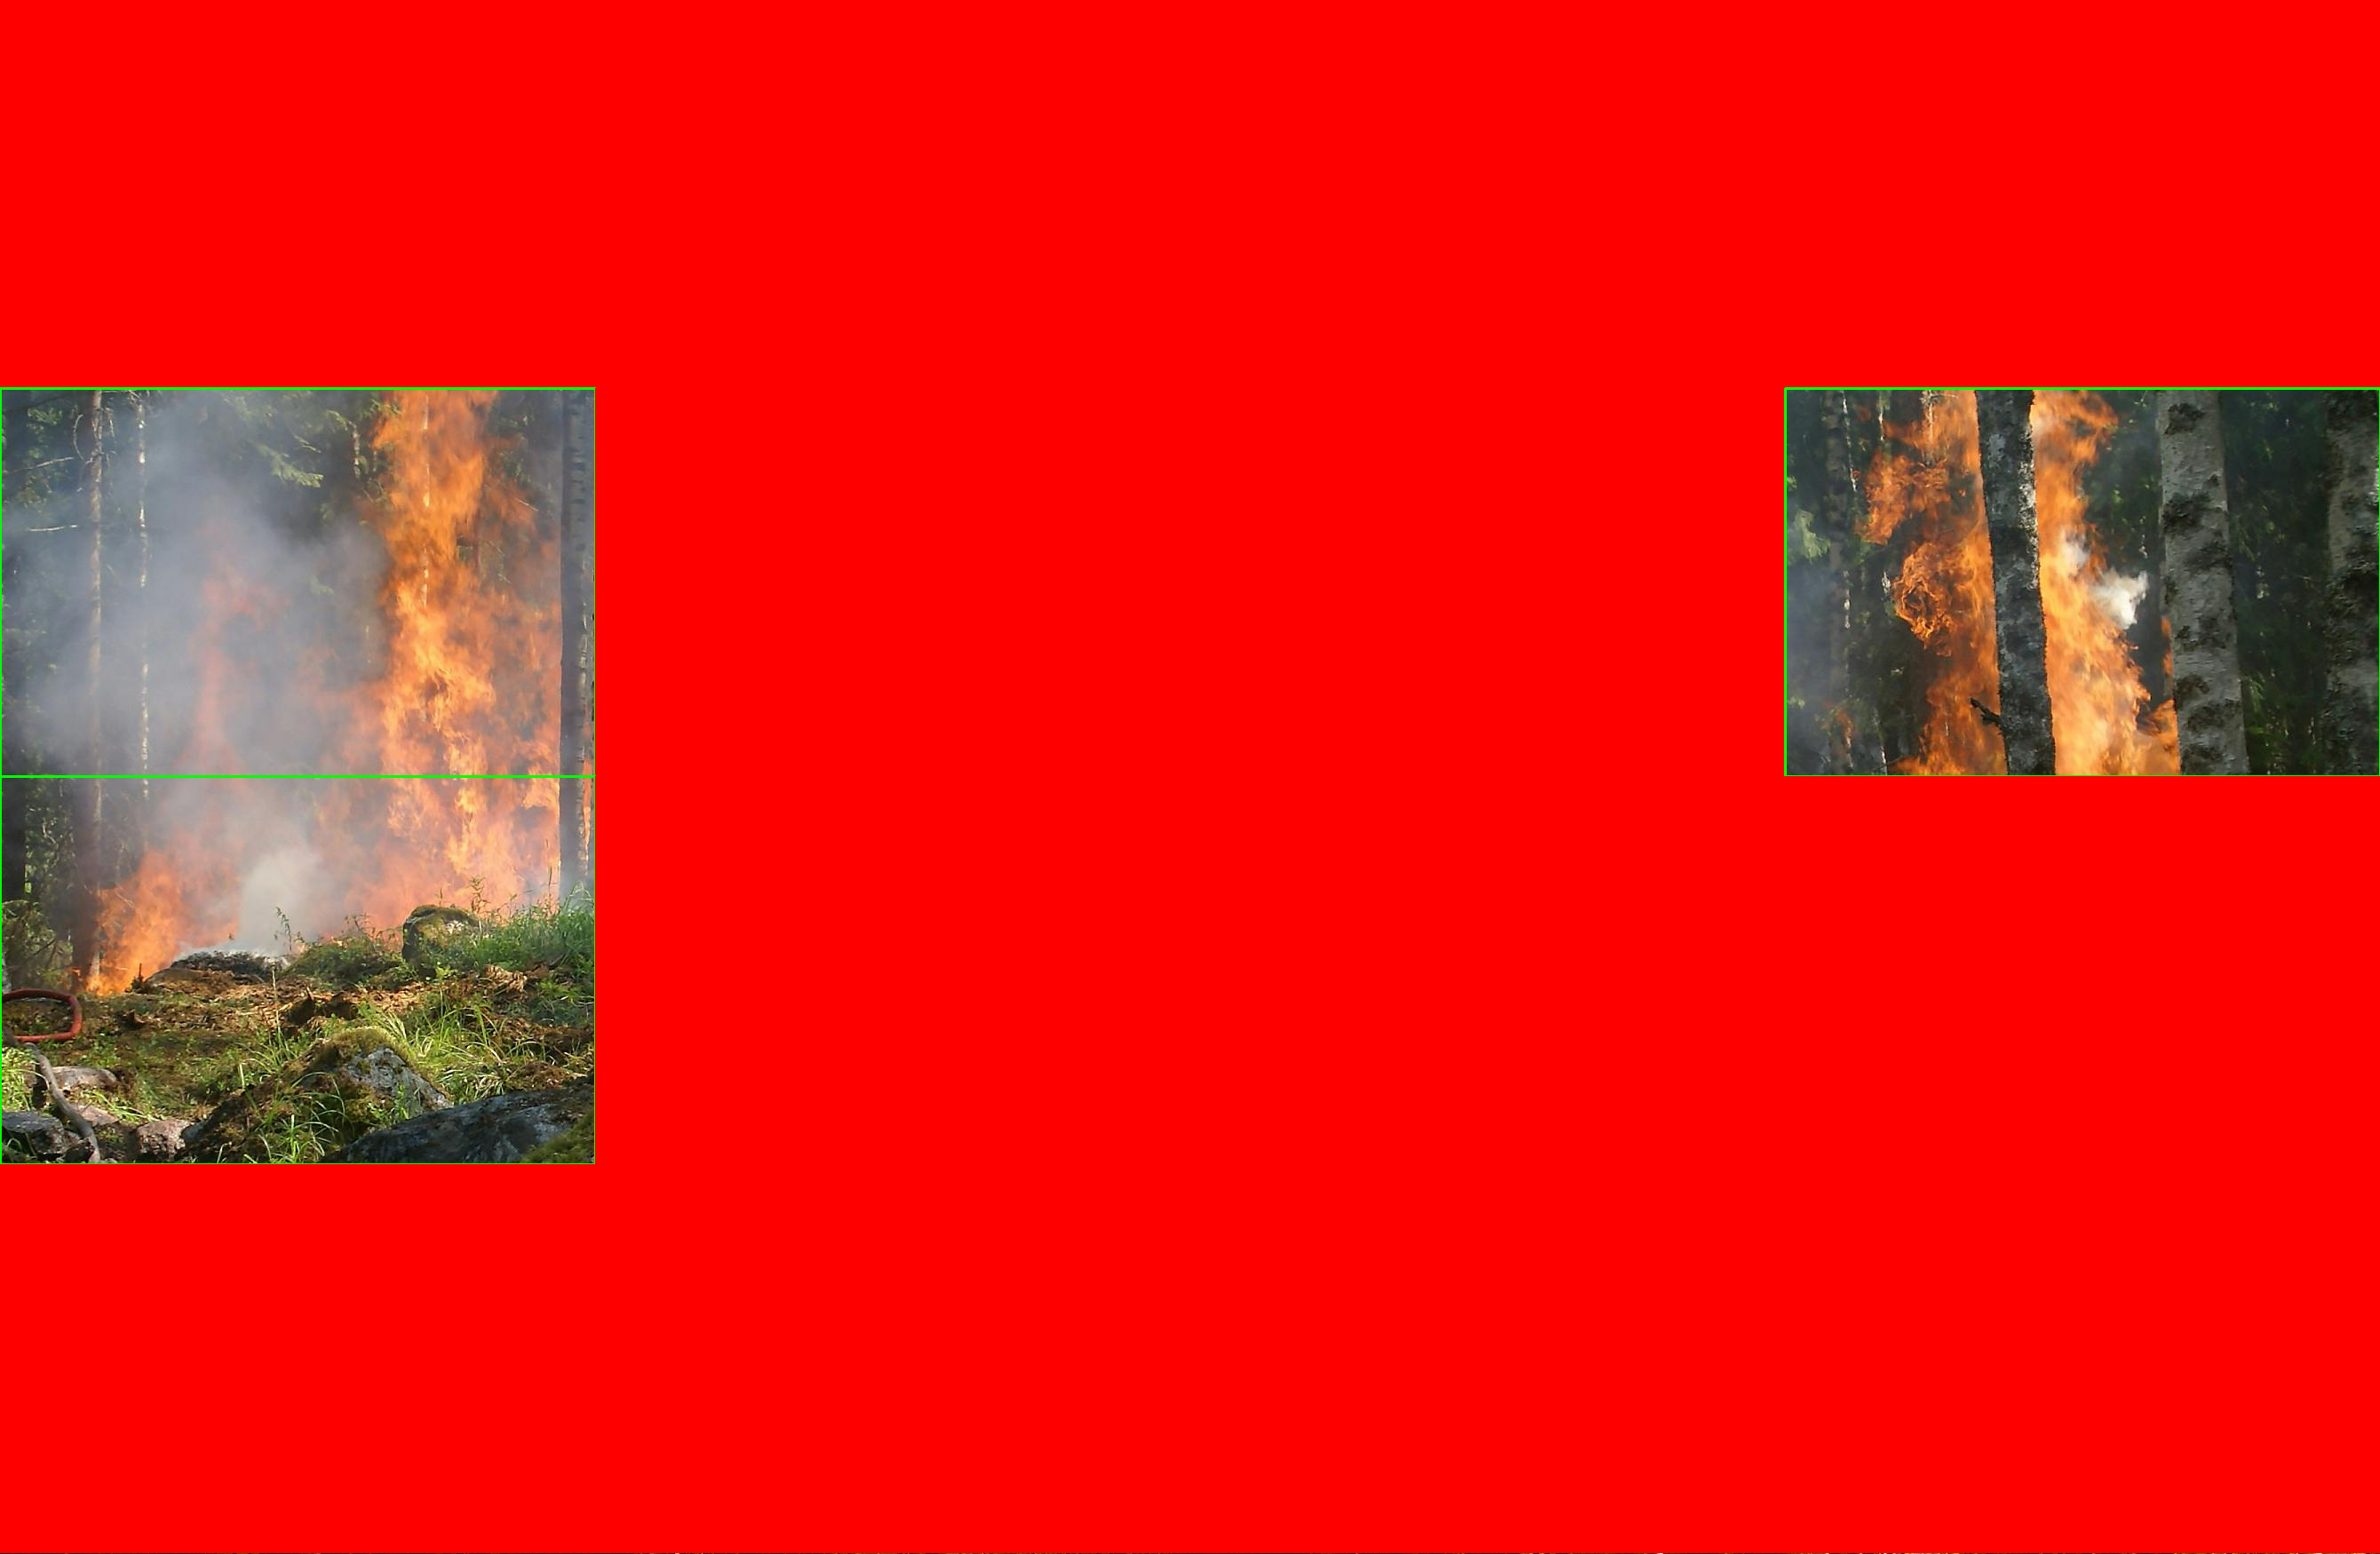

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Processed /content/drive/MyDrive/testfolder/ff2.jpg in 3.54 seconds


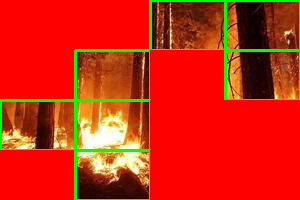

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import time
import os
import glob

# Check if running in Google Colab
try:
    from google.colab.patches import cv2_imshow
    COLAB_ENV = True
except ImportError:
    COLAB_ENV = False

# Load the trained MobileNetV2 model
model = tf.keras.models.load_model("/content/drive/MyDrive/IOT MINI Project/wildfire.h5")  # Update with actual model path

def preprocess_image(img, target_size=(224, 224)):
    """Preprocess image for MobileNetV2 input."""
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def detect_fire_with_grid(image_path, grid_size=(4, 4), threshold=0.5):
    """Detects fire in different grid regions of the image."""

    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ OpenCV failed to load the image: {image_path}")
        return None, None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    cell_h, cell_w = height // grid_size[0], width // grid_size[1]

    fire_map = np.zeros(grid_size)

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            x1, y1 = j * cell_w, i * cell_h
            x2, y2 = x1 + cell_w, y1 + cell_h
            patch = image[y1:y2, x1:x2]
            processed_patch = preprocess_image(patch)
            prediction = model.predict(processed_patch)[0, 0]

            if prediction >= threshold:
                fire_map[i, j] = 1
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), -1)  # Highlight fire
            else:
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Normal grid

    return image, fire_map

# Process all images in the folder
folder_path = "/content/drive/MyDrive/testfolder/"  # Update with actual folder path
image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))  # Adjust extension if needed

for img_path in image_paths:
    start_time = time.time()
    detected_image, fire_map = detect_fire_with_grid(img_path)
    end_time = time.time()

    if detected_image is not None:
        print(f"Processed {img_path} in {end_time - start_time:.2f} seconds")
        if COLAB_ENV:
            cv2_imshow(cv2.cvtColor(detected_image, cv2.COLOR_RGB2BGR))  # For Colab
        else:
            cv2.imshow("Fire Detection Grid", cv2.cvtColor(detected_image, cv2.COLOR_RGB2BGR))
            cv2.waitKey(0)

cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Processed /content/drive/MyDrive/testfolder/ds.jpg in 3.67 seconds


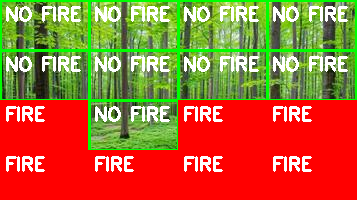

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Processed /content/drive/MyDrive/testfolder/ff.jpg in 2.49 seconds


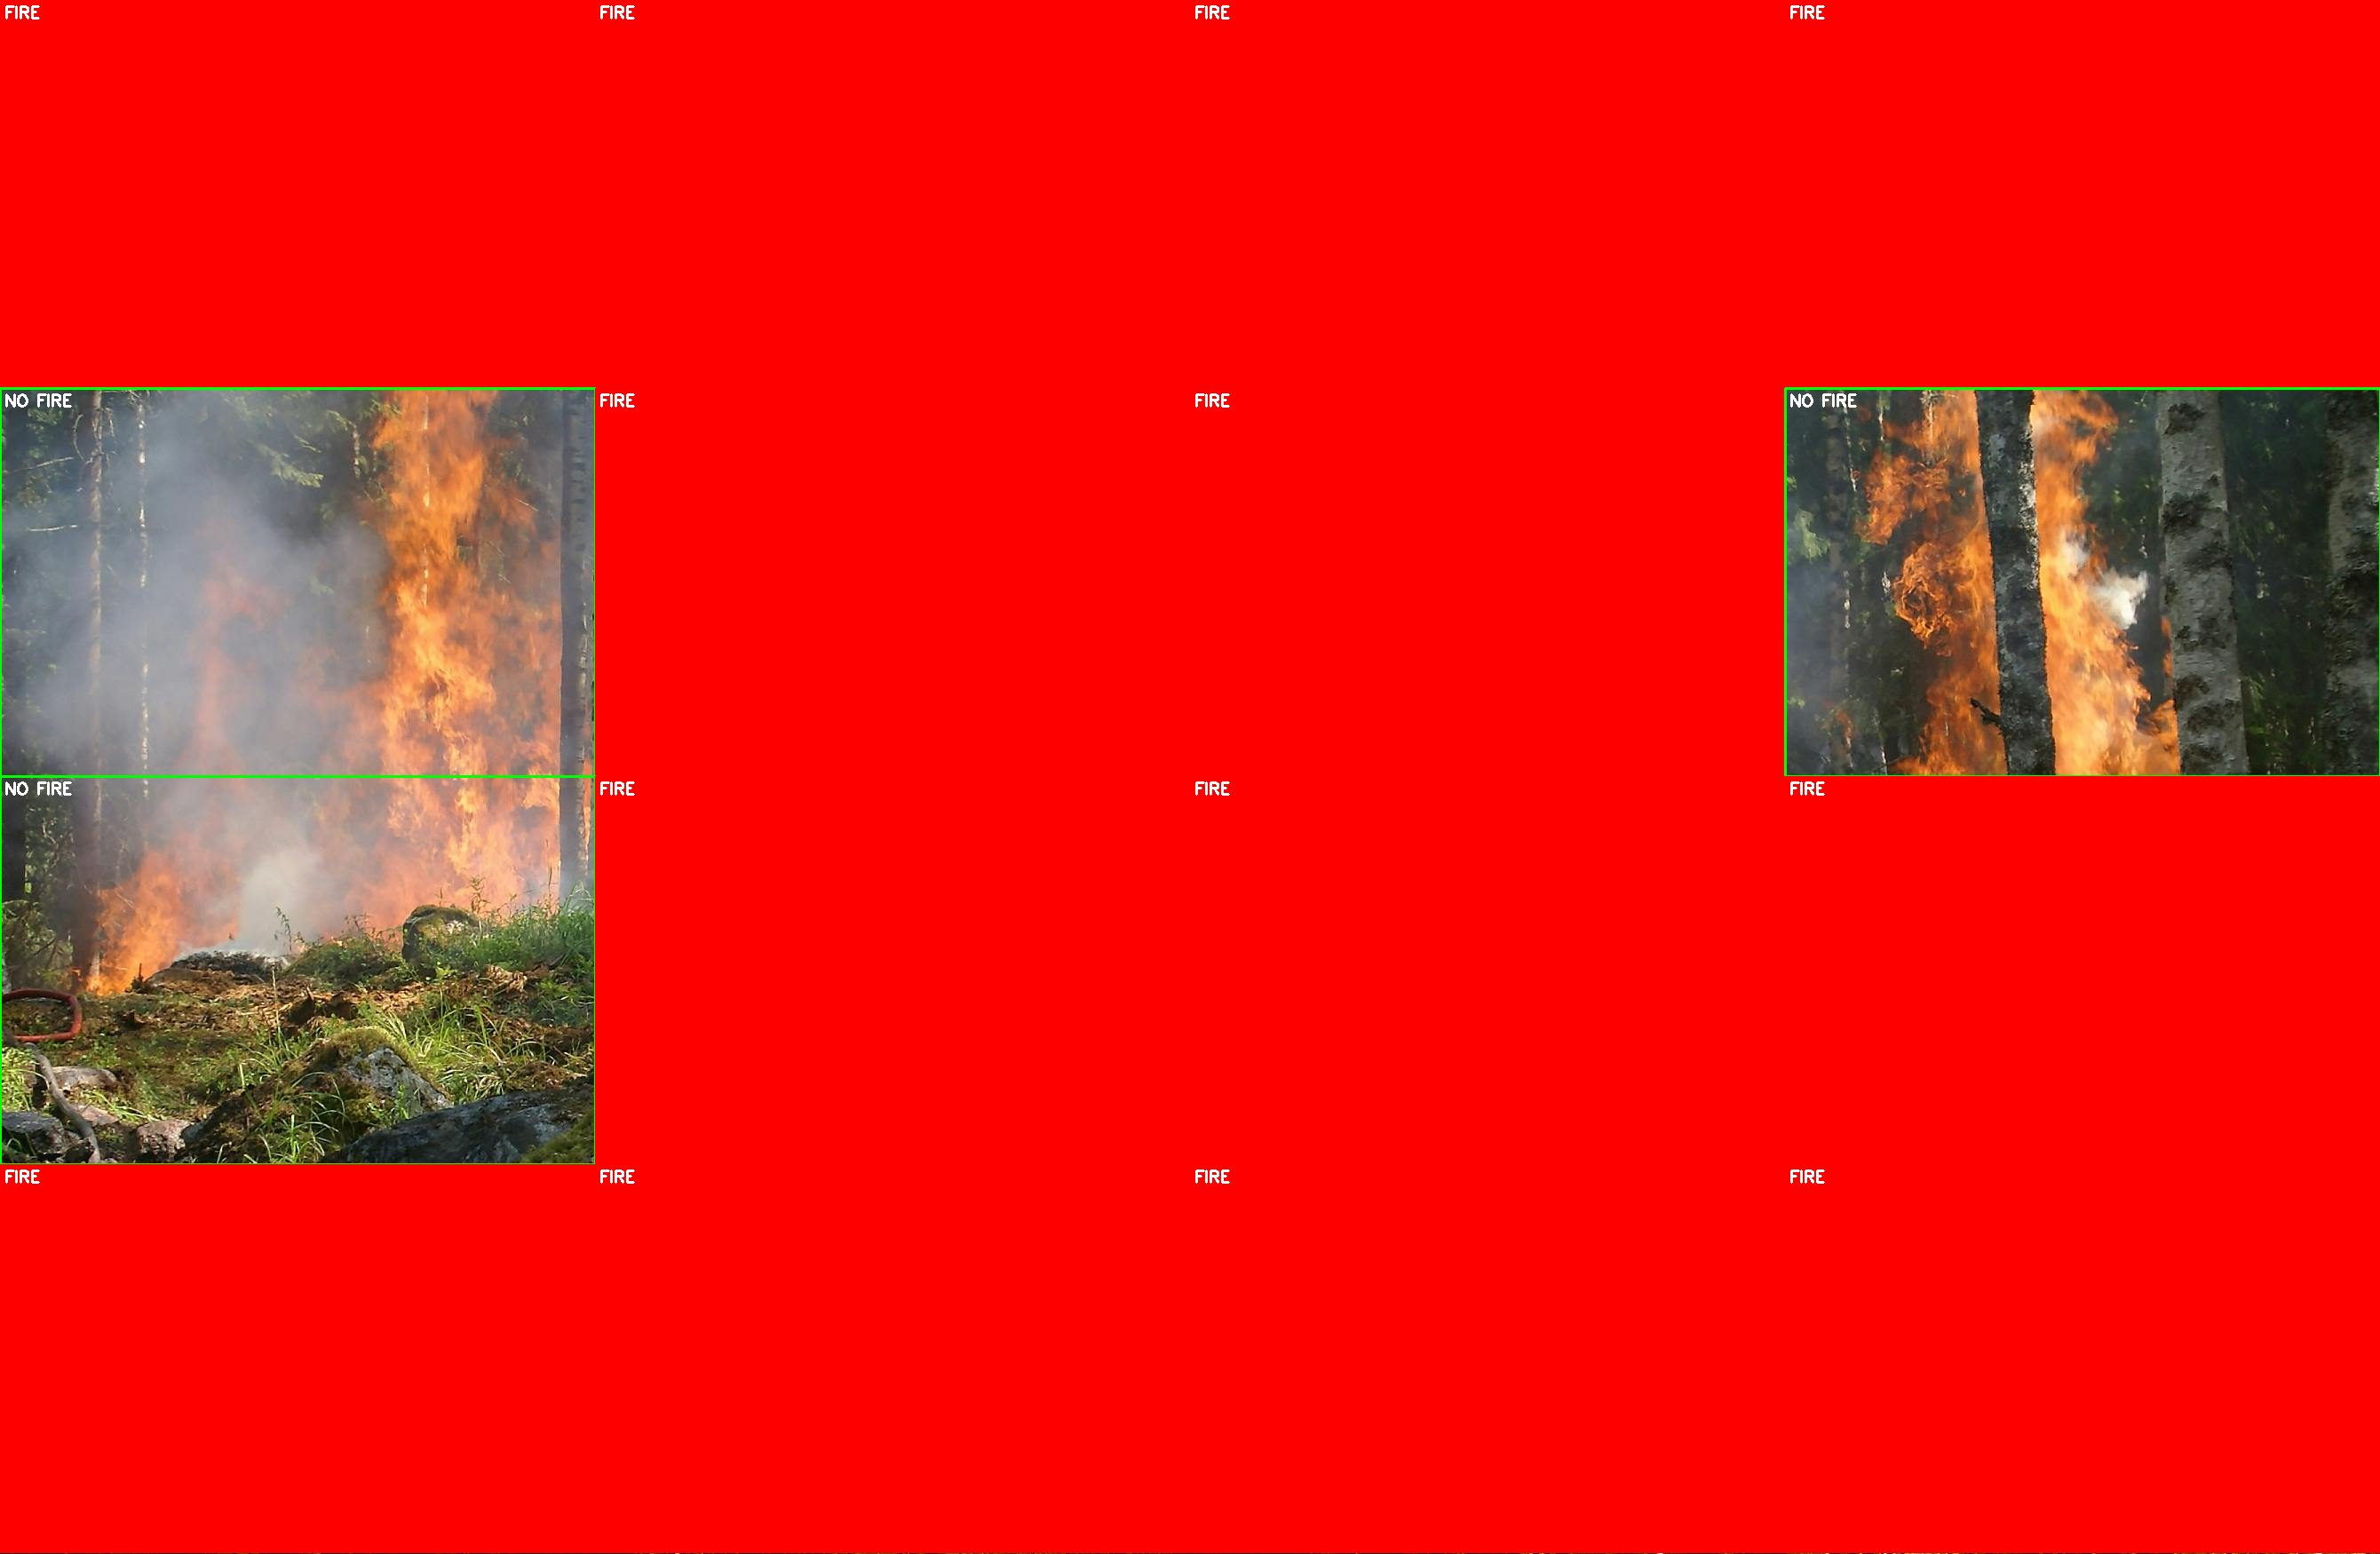

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Processed /content/drive/MyDrive/testfolder/ff2.jpg in 3.73 seconds


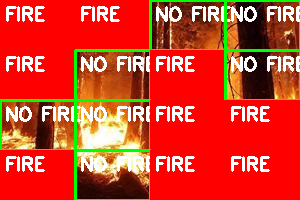

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import time
import os
import glob

# Check if running in Google Colab
try:
    from google.colab.patches import cv2_imshow
    COLAB_ENV = True
except ImportError:
    COLAB_ENV = False

# Load the trained MobileNetV2 model
model = tf.keras.models.load_model("/content/drive/MyDrive/IOT MINI Project/wildfire.h5")  # Update with actual model path

def preprocess_image(img, target_size=(224, 224)):
    """Preprocess image for MobileNetV2 input."""
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def detect_fire_with_grid(image_path, grid_size=(4, 4), threshold=0.5):
    """Detects fire in different grid regions of the image."""

    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ OpenCV failed to load the image: {image_path}")
        return None, None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    cell_h, cell_w = height // grid_size[0], width // grid_size[1]

    fire_map = np.zeros(grid_size)

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            x1, y1 = j * cell_w, i * cell_h
            x2, y2 = x1 + cell_w, y1 + cell_h
            patch = image[y1:y2, x1:x2]
            processed_patch = preprocess_image(patch)
            prediction = model.predict(processed_patch)[0, 0]

            if prediction >= threshold:
                fire_map[i, j] = 0
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), -1)  # Highlight fire
                cv2.putText(image, "FIRE", (x1 + 5, y1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            else:
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Normal grid
                cv2.putText(image, "NO FIRE", (x1 + 5, y1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    return image, fire_map

# Process all images in the folder
folder_path = "/content/drive/MyDrive/testfolder/"  # Update with actual folder path
image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))  # Adjust extension if needed

for img_path in image_paths:
    start_time = time.time()
    detected_image, fire_map = detect_fire_with_grid(img_path)
    end_time = time.time()

    if detected_image is not None:
        print(f"Processed {img_path} in {end_time - start_time:.2f} seconds")
        if COLAB_ENV:
            cv2_imshow(cv2.cvtColor(detected_image, cv2.COLOR_RGB2BGR))  # For Colab
        else:
            cv2.imshow("Fire Detection Grid", cv2.cvtColor(detected_image, cv2.COLOR_RGB2BGR))
            cv2.waitKey(0)

cv2.destroyAllWindows()
